### Initialization
* Check whether the runtime is host or local.
* Mount Google Drive when using the host runtime.

In [1]:
try:
  from google.colab import drive
  drive.mount('/gdrive')
  runtime = "host"
except:
  runtime = "local"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Parameters

In [0]:
#@title Parameters
#@markdown |Name            |Description|
#@markdown |:---            |:---|
#@markdown |`seed`|The random seed|
seed = 3984 #@param {type: "number"}

#@markdown ### `deep-coder` Repositories
#@markdown |Name            |Description|
#@markdown |:---            |:---|
#@markdown |`repository_url`|The URL of `deep-coder` git repository (enabled only in the host runtime)|
#@markdown |`branch_name`   |The branch name (enabled only in the host runtime)|
repository_url = "https://github.com/HiroakiMikami/deep-coder" #@param {type: "string"}
branch_name = "master" #@param {type: "string"}

#@markdown ### Filepathes
#@markdown |Name                |Description|
#@markdown |:---                |:---|
#@markdown |`valid_dataset_path`|The file path of the validation dataset|
#@markdown |`result_pathes`     |The comma separated list of the validation results|
valid_dataset_path = "/gdrive/My Drive/DeepCoder/dataset/length_3/valid.pickle" #@param {type: "string"}
result_pathes = "/gdrive/My Drive/DeepCoder/out/length_3/baseline/result.pickle,/gdrive/My Drive/DeepCoder/out/length_3/deep-coder/result.pickle" #@param {type: "string"}
result_path_list = list(result_pathes.split(","))

### Setup
* Fix the random seed
* Download the codebase (when using the host runtime)
  1. Clone git repository and move to the specified branch
  2. Initialize submodule
  3. Build the `search` tool
  4. Install chainer and cupy

In [0]:
import numpy as np
import random

SEED_MAX = 2**32 - 1

root_rng = np.random.RandomState(seed)
random.seed(root_rng.randint(SEED_MAX))
np.random.seed(root_rng.randint(SEED_MAX))

In [4]:
if runtime == "host":
  %cd /content
  !rm -rf deep-coder
  ![ ! -e deep-coder ] && git clone $repository_url deep-coder
  %cd deep-coder
  !git checkout origin/$branch_name
  !git submodule init
  !git submodule update
  !make -C DeepCoder_Utils/enumerative-search -j `nproc`
  !curl https://colab.chainer.org/install | sh -

/content
Cloning into 'deep-coder'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 1283 (delta 92), reused 64 (delta 34), pack-reused 1124
Receiving objects: 100% (1283/1283), 17.84 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (770/770), done.
/content/deep-coder
Note: checking out 'origin/master'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at cbf6f06 Add example script to generate the dataset
Submodule 'DeepCoder_Utils' (https://github.com/HiroakiMikami/DeepCoder-Utils.git) registered for path 'DeepCoder_Utils

### Load Dataset and Results
* Load dataset
* Load results

In [0]:
import pickle

# Load model
with open(valid_dataset_path, "rb") as f:
    valid_dataset = pickle.load(f)

# Load results
results = dict()
for path in result_path_list:
    with open(path, "rb") as f:
        results[path] = pickle.load(f)


### Visualize Results


* Show the time needed to solve

In [0]:
#@markdown ### Visualization Parameters
#@markdown |Name    |Description|
#@markdown |:---    |:---|
#@markdown |`width` |The width of the matplotlib plot|
#@markdown |`height`|The height of the matplotlib plot|
width = 12 #@param {type: "slider", min: 1, max: 48, step: 1}
height = 4 #@param {type: "slider", min: 1, max: 48, step: 1}


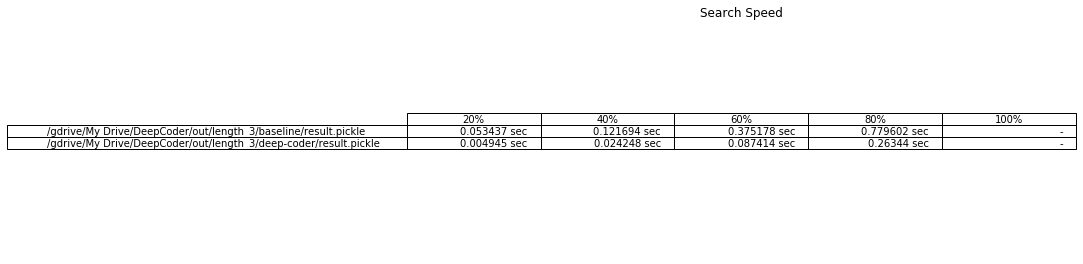

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(width, height))

required_times = dict()
for path in results.keys():
    t = [r.time_seconds for r in results[path].values() if r.is_solved]
    t.sort()
    required_times[path] = t

plt.axis("tight")
plt.axis("off")
plt.title("Search Speed")

rowLabels = list(results.keys())
colLabels = ["20%", "40%", "60%", "80%", "100%"]

text = []
for path in rowLabels:
    r = 0.0
    t = required_times[path]
    row = []
    for i in range(5):
        r += 0.2
        num = int(len(valid_dataset.dataset) * r)
        row.append("{} sec".format(t[num]) if len(t) > num else "-")
    text.append(row)

plt.table(cellText=text, colLabels=colLabels,
               rowLabels=rowLabels, loc="center")

* Show the nodes exploration needed to solve

In [0]:
#@markdown ### Visualization Parameters
#@markdown |Name    |Description|
#@markdown |:---    |:---|
#@markdown |`width` |The width of the matplotlib plot|
#@markdown |`height`|The height of the matplotlib plot|
width = 12 #@param {type: "slider", min: 1, max: 48, step: 1}
height = 4 #@param {type: "slider", min: 1, max: 48, step: 1}


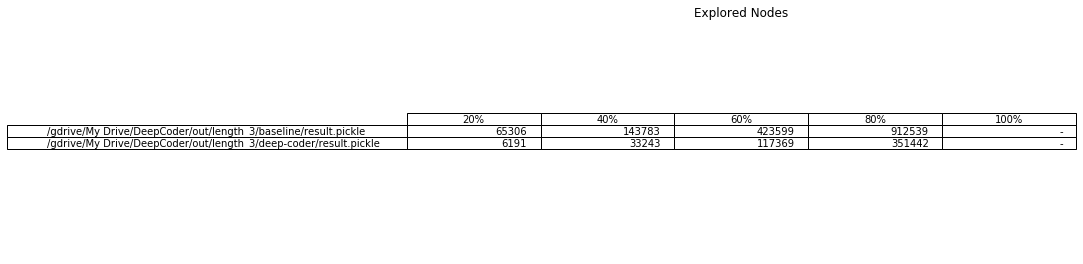

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(width, height))

required_nodes = dict()
for path in results.keys():
    n = [r.explored_nodes for r in results[path].values() if r.is_solved]
    n.sort()
    required_nodes[path] = n

plt.axis("tight")
plt.axis("off")
plt.title("Explored Nodes")

rowLabels = list(results.keys())
colLabels = ["20%", "40%", "60%", "80%", "100%"]

text = []
for path in rowLabels:
    r = 0.0
    t = required_nodes[path]
    row = []
    for i in range(5):
        r += 0.2
        num = int(len(valid_dataset.dataset) * r)
        row.append("{}".format(t[num]) if len(t) > num else "-")
    text.append(row)

plt.table(cellText=text, colLabels=colLabels,
               rowLabels=rowLabels, loc="center")

* Show the detail of the specified entry

In [0]:
#@markdown ### Visualization Parameters
#@markdown |Name    |Description|
#@markdown |:---    |:---|
#@markdown |`width` |The width of the matplotlib plot|
#@markdown |`height`|The height of the matplotlib plot|
#@markdown |`index`  |The index of the specified entry|
width = 36 #@param {type: "slider", min: 1, max: 48, step: 1}
height = 1 #@param {type: "slider", min: 1, max: 48, step: 1}
index = 0 #@param {type: "number"}


Valid 0
Examples
Example 0
  input 0: [6, 3, -6, 4, 0, -2, -2, 0, 4, 4, 2, 6, 3, -2, 7, 7, -3, -4, 0, -6]
  input 1: [-3, -2, -5, 5, -5, -6, 7, 3, 3, -3, 1, 5, 2, 5, -1, -3, 0, -1, -2, 7]
  output: [20, 6, 0, 0, 6, 4, 20, 2, 0, 12, 0, 0, 0, 12, 16, 25, 2, 2, 1, 42]
Example 1
  input 0: [-6, -6, -3, 6, 2, -2, -2, 4, 1, 5, 7, -4, -3, 6, 1, -4, -2, 1, -2, -4]
  input 1: [-6, 5, -2, -6, 7, 1, -1, -1, -6, 1, -6, -6, 1, 6, 0, 1, 0, 3, -4, -2]
  output: [0, 30, 0, 36, 6, 2, 0, 6, 12, 4, 42, 1, 4, 0, 0, 6, 1, 1, 1, 1]
Example 2
  input 0: [-2, 5, 3, -5, 1, -2, -6, -6, -1, 2, 6, 5, 6, 0, 0, 0, -2, 5, -1, -3]
  input 1: [-5, 2, 7, -2, 1, 7, -5, -3, 6, -1, -5, -6, 2, -1, 0, -5, 4, 2, 2, -6]
  output: [2, 2, 4, 2, 0, 20, 0, 2, 12, 2, 30, 30, 4, 0, 0, 6, 9, 2, 2, 2]
Example 3
  input 0: [2, -4, 5, 6, -6, 4, 6, 0, 0, -5, 1, 0, 3, -5, -4, -3, 3, 4, 4, 2]
  input 1: [0, 5, 1, -1, -5, 7, 1, 3, 6, 6, -2, -2, 1, 1, 7, 6, 6, 0, 0, 1]
  output: [1, 20, 4, 12, 0, 2, 6, 2, 9, 30, 2, 1, 1, 9, 30, 20, 2, 4, 4,

([<matplotlib.axis.YTick at 0x7f03d6587c88>,
 <a list of 3 Text yticklabel objects>)

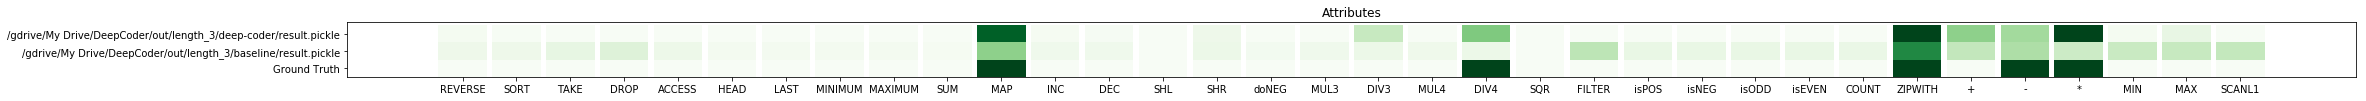

In [11]:
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

m = cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap=cm.Greens)

plt.figure(figsize=(width, height))
    
entry = valid_dataset.dataset[index][0]
print("Valid {}".format(index))
print("Examples")
for i, example in enumerate(entry.examples):
    print("Example {}".format(i))
    for j, input in enumerate(example.inputs):
        print("  input {}: {}".format(j, input))
    print("  output: {}".format(example.output))
print()

print("Source Code")
print("Ground Truth")
print(entry.source_code)
print()
for path, result in results.items():
    print(path)
    print(result[index].solution)
    print()

plt.title("Attributes")
labels = ["Ground Truth"]
ticks = [0.5]
data = np.ones(len(entry.attribute))
colors = []
for _, v in entry.attribute.items():
    colors.append(m.to_rgba(1 if v else 0))
xs = np.arange(len(entry.attribute))
plt.bar(xs, data, width=0.9, bottom=np.zeros(1),
        color=colors, tick_label=list(entry.attribute.keys()))

for i, (path, result) in enumerate(results.items()):
    labels.append(path)
    ticks.append(i + 1.5)
    colors = []
    for key in entry.attribute.keys():
        colors.append(m.to_rgba(result[index].probabilities[key]))
    plt.bar(xs, data, width=0.9, bottom=np.ones(1) * (i + 1), color=colors,
            tick_label=list(entry.attribute.keys()))

plt.yticks(ticks=ticks, labels=labels)
